# Kaggle Competition for the Data Science Class Maastricht University

## Team: It's free real estate

Note: Crossvalidation was used to test and optimize most algorithms. But it is extremely hard on the CPU for algorithms. So cross validation has been left out in this notebook, such that running time is minimized

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Our Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV

import lightgbm as LGB

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats

## 1. Basics of the data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
solution = pd.read_csv('data/sample_sol.csv')

train.shape

(13035, 12)

### 1.1 Check basic information on the dataset

In [3]:
print('Dimensions:', train.shape, '\n')
print('Types:', train.dtypes, '\n')
print('Missing Values:', train.isnull().sum(), '\n')

# Get 5 random samples
train.sample(n = 5)

Dimensions: (13035, 12) 

Types: season          int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object 

Missing Values: season        0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64 



,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
986,1,2,19,0,1,1,3,0.44,0.4394,0.88,0.6119,80
6879,1,1,14,0,1,1,3,0.22,0.2273,0.93,0.1940,61
6022,4,12,22,0,2,1,3,0.46,0.4545,1.00,0.1642,87
10272,3,7,12,0,1,1,2,0.76,0.7121,0.58,0.1045,278
8082,2,4,1,0,0,0,2,0.36,0.3485,0.76,0.1642,62


Dataset seems to be quite clean. No missing values

### 1.2 Quick first look at the dataset

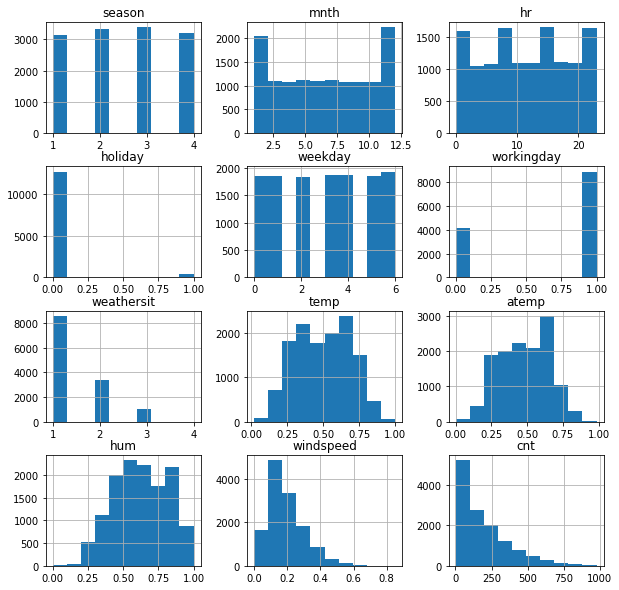

In [4]:
fig, axes = plt.subplots(len(train.columns)//3, 3, figsize=(10, 10))

i = 0
for triaxis in axes:
    for axis in triaxis:
        train.hist(column = train.columns[i], ax=axis)
        i = i + 1

1. Interestingly 2 months are more prevelant than others.
2. Weather condition 4 is almost non existant

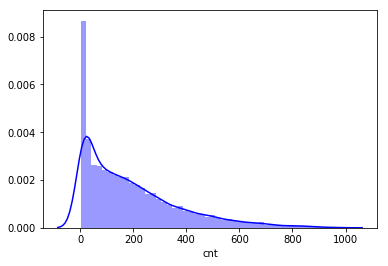

In [5]:
sns.distplot(train["cnt"], color ='blue')

We see that the rental count almost is a half normal distribution

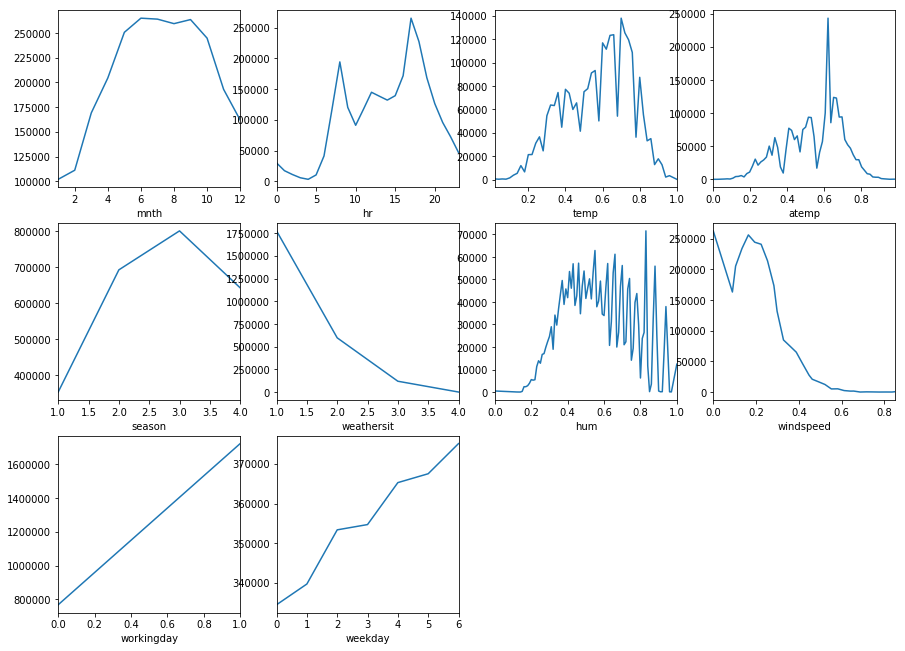

In [6]:
plt.figure(figsize=(15, 15))

plt.subplot(4, 4, 1)
train.groupby('mnth').cnt.sum().plot()

plt.subplot(4, 4, 2)
train.groupby('hr').cnt.sum().plot()

plt.subplot(4, 4, 3)
train.groupby('temp').cnt.sum().plot()

plt.subplot(4, 4, 4)
train.groupby('atemp').cnt.sum().plot()

plt.subplot(4, 4, 5)
train.groupby('season').cnt.sum().plot()

plt.subplot(4, 4, 6)
train.groupby('weathersit').cnt.sum().plot()

plt.subplot(4, 4, 7)
train.groupby('hum').cnt.sum().plot()

plt.subplot(4, 4, 8)
train.groupby('windspeed').cnt.sum().plot()

plt.subplot(4, 4, 9)
train.groupby('workingday').cnt.sum().plot()

plt.subplot(4, 4, 10)
train.groupby('weekday').cnt.sum().plot()

plt.show()

We can clearly see that these features are quite important when it comes to the count

1. The month highly defines how many bikes will be rented out.
2. There seem to be some peak hours in the hours of rental
3. There is a sweet spot when it comes to temperature
4. The "feel" temperature is closely related to the temperature
5. It makes sense that the count is related to the season
6. Obviously the worse the weather the less bikes are being rented

Let's check if the temperature, hour and season meets our expectation

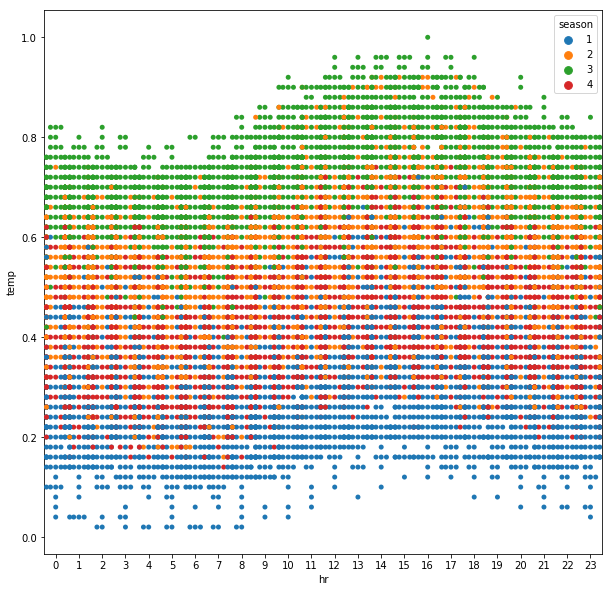

In [7]:
plt.figure(figsize=(10, 10))
sns.swarmplot(x = 'hr', y = 'temp', data = train, hue = 'season')
plt.show()

Check some weather condition data

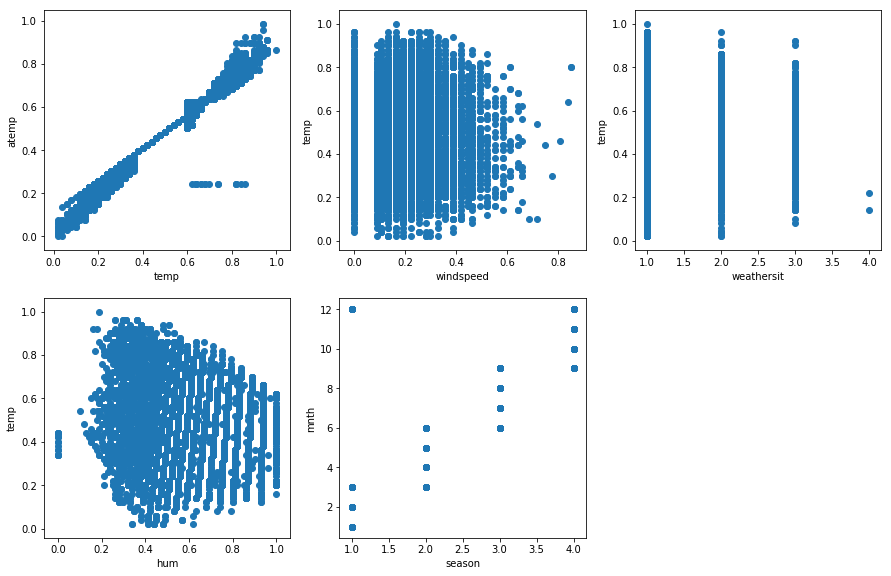

In [8]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 1)
plt.xlabel('temp')
plt.ylabel('atemp')
plt.scatter(x = train.temp, y = train.atemp)


plt.subplot(3, 3, 2)
plt.xlabel('windspeed')
plt.ylabel('temp')
plt.scatter(x = train.windspeed, y = train.temp)

plt.subplot(3, 3, 3)
plt.xlabel('weathersit')
plt.ylabel('temp')
plt.scatter(x = train.weathersit, y = train.temp)

plt.subplot(3, 3, 4)
plt.xlabel('hum')
plt.ylabel('temp')
plt.scatter(x = train.hum, y = train.temp)

plt.subplot(3, 3, 5)
plt.xlabel('season')
plt.ylabel('mnth')
plt.scatter(x = train.season, y = train.mnth)

plt.show()

1. Note that some months in december are marked as season 1. We will correct this later
2. Also there seem to be some anomalies in the atemp vs temp

Is there a difference in behaviour during work days or not?

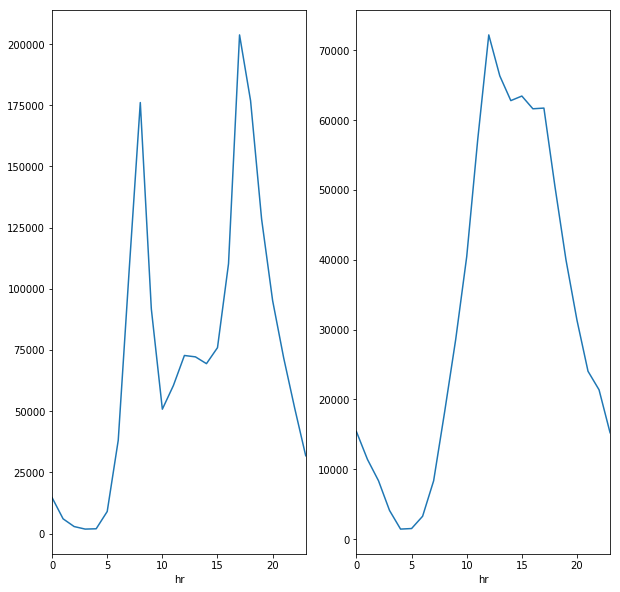

In [9]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)

workdays = train.loc[train.workingday == 1]
workdays.groupby('hr').cnt.sum().plot()

plt.subplot(1, 2, 2)
not_workdays = train.loc[train.workingday == 0]
not_workdays.groupby('hr').cnt.sum().plot()

Clearly there is a difference.

## 2. Feature Engineering

Let's correct that december being the wrong season thing

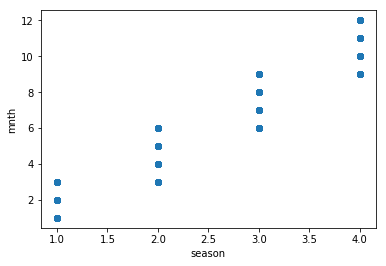

In [10]:
train.loc[train.mnth == 12, 'season'] = 4
test.loc[test.mnth == 12, 'season'] = 4

plt.xlabel('season')
plt.ylabel('mnth')
plt.scatter(x = train.season, y = train.mnth)

plt.show()

First we have to separate the categorical data into their own columns to emphasize the features

In [11]:
season_dummies = pd.get_dummies(train.season, prefix = 'season')
train = pd.concat([train, season_dummies], axis = 1)

season_dummies = pd.get_dummies(test.season, prefix = 'season')
test = pd.concat([test, season_dummies], axis = 1)

weathersit_dummies = pd.get_dummies(train.weathersit, prefix = 'weathersit')
train = pd.concat([train, weathersit_dummies], axis = 1)

weathersit_dummies = pd.get_dummies(test.weathersit, prefix = 'weathersit')
test = pd.concat([test, weathersit_dummies], axis = 1)

train.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40,1,0,0,0,1,0,0,0
1,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32,1,0,0,0,1,0,0,0
2,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,1,0,0,0,1,0,0,0
3,1,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,1,1,0,0,0,0,1,0,0
4,1,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,1,0,0,0,1,0,0,0


Drop the columns we just categorized

In [12]:
train = train.drop(['season', 'weathersit'], axis = 1)
test = test.drop(['season', 'weathersit'], axis = 1)

Let's check the correlation of each value

In [13]:
train = train.drop(['atemp'], axis = 1)
test = test.drop(['atemp'], axis = 1)

atemp is almost the same as temp, which can make our system to dependant on those variables. So we will drop atemp

<function matplotlib.pyplot.show(*args, **kw)>

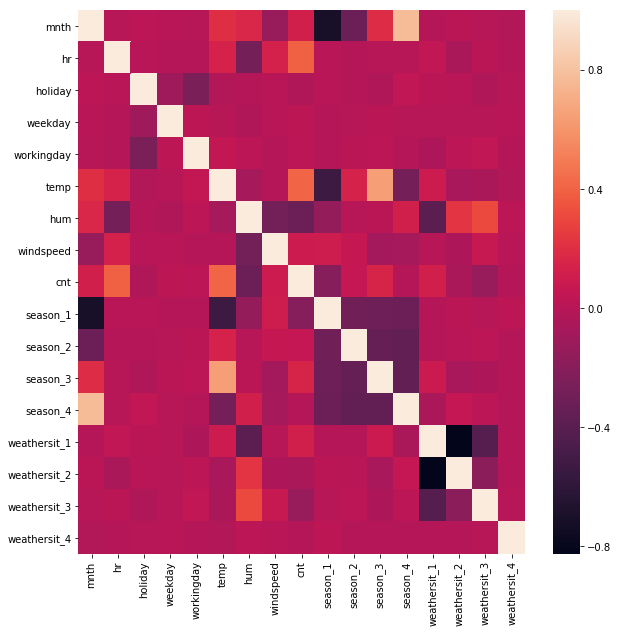

In [14]:
plt.figure(figsize=(10, 10))

sns.heatmap(train.corr())
plt.show

### Adding more features

As we have seen, there are certain best hours where most bikes are rented. Let's try to categorize that

Credits to https://github.com/logicalguess for this idea

In [15]:
train['hour_best'] = train[['hr', 'workingday']].apply(lambda is_best: (0, 1)
                                                      [((is_best['workingday'] == 1 and  (7 <= is_best['hr'] <= 9 or 17 <= is_best['hr'] <= 18)) or
                                                       (is_best['workingday'] == 0 and  (11 <= is_best['hr'] <= 18)))], axis = 1)

test['hour_best'] = test[['hr', 'workingday']].apply(lambda is_best: (0, 1)
                                                      [((is_best['workingday'] == 1 and  (7 <= is_best['hr'] <= 9 or 17 <= is_best['hr'] <= 18)) or
                                                       (is_best['workingday'] == 0 and  (11 <= is_best['hr'] <= 18)))], axis = 1)

E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


In [16]:
train.sample(n = 5)

,mnth,hr,holiday,weekday,workingday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,hour_best
10201,7,9,0,4,1,0.72,0.70,0.1343,344,0,0,1,0,0,1,0,0,1
10230,7,21,0,5,1,0.78,0.59,0.1045,260,0,0,1,0,1,0,0,0,0
6308,12,9,0,4,1,0.38,0.87,0.0896,228,0,0,0,1,0,1,0,0,1
10514,8,14,0,1,1,0.80,0.33,0.1045,248,0,0,1,0,1,0,0,0,0
7933,3,12,0,5,1,0.66,0.61,0.2239,471,0,1,0,0,0,1,0,0,0


## 3. Modeling

I've spent much time hypertuning parameters and testing different models.

XGBoost very very finely tuned gave me the best result on the leaderboard with: 60.02621

So if you are looking for an okay score, run XGBoost with the parameters in this notebook

In this notebook I will try to use a blend and see what result I end up with

In [17]:
train_set, test_set = train_test_split(train, test_size = 0.3, random_state = 42)

x_train = train_set.drop('cnt', axis = 1)
y_train = train_set.cnt

x_test = test_set.drop('cnt', axis = 1)
y_test = test_set.cnt

Split training data from test.

P.S. 42 is the answer

Let's get a baseline for each model

67.98380693683724
[3.91025879e-02 2.49408481e-01 5.19656596e-03 2.33399047e-02
 3.22260124e-02 1.19706112e-01 5.88797285e-02 2.38721870e-02
 3.44934915e-02 4.87192455e-03 8.52820755e-03 6.07927867e-03
 1.01328857e-02 5.99313303e-03 1.62408724e-02 2.72790698e-06
 3.61925899e-01]


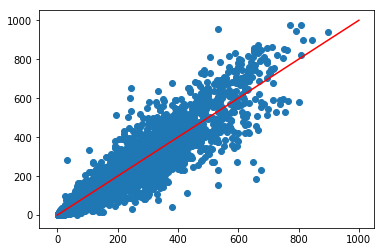

In [18]:
et_model = ExtraTreesRegressor(n_estimators = 600, random_state = 42, n_jobs = -1, max_features = 9, min_samples_split = 4, max_depth = 20)
et_model.fit(x_train, y_train)

et_y_pred = np.floor(et_model.predict(x_test))

print(np.sqrt(mean_squared_error(y_test, et_y_pred)))
print(et_model.feature_importances_)

plt.plot([0,1000],[0,1000], color='red')
plt.scatter(et_y_pred, y_test)
plt.show()

67.01520223505995
[4.55912526e-02 2.90113003e-01 3.62828602e-03 2.87919594e-02
 2.26856177e-02 1.49130021e-01 7.77910904e-02 3.44313462e-02
 1.28433043e-02 3.33450668e-03 3.82567059e-03 4.45439995e-03
 7.23995512e-03 4.53077059e-03 1.21681494e-02 9.81273329e-07
 2.99439686e-01]


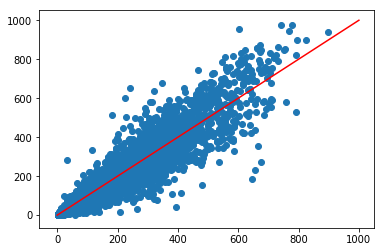

In [19]:
rf_model = RandomForestRegressor(n_estimators = 825, random_state = 42, n_jobs = -1, max_features = 8, min_samples_split = 2)
rf_model.fit(x_train, y_train)

rf_y_pred = np.floor(rf_model.predict(x_test))

print(np.sqrt(mean_squared_error(y_test, rf_y_pred)))
print(rf_model.feature_importances_)

plt.plot([0,1000],[0,1000], color='red')
plt.scatter(rf_y_pred, y_test)
plt.show()

This one takes a while if on a weak computer

64.91645595806156
[1.2363239e-01 1.5711160e-01 1.1925601e-02 1.0484136e-01 1.7778993e-02
 1.7770788e-01 1.8093544e-01 1.4316192e-01 5.6619258e-03 1.2500000e-02
 5.3610504e-03 2.2428883e-03 1.8708972e-02 8.6159734e-03 1.3977024e-02
 2.7352298e-05 1.5809627e-02]


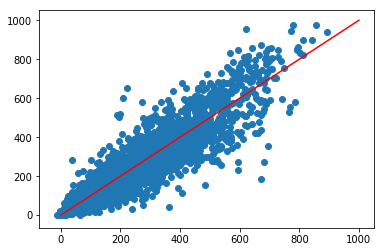

In [20]:
xgb_model = XGBRegressor(n_estimators = 142, early_stopping_rounds=10, learning_rate = 0.1,
                     random_state = 42, nthread = 64, max_depth = 9, gamma = 5, reg_lambda = 5,
                     reg_alpha = 13)
xgb_model.fit(x_train, y_train)

xgb_y_pred = np.floor(xgb_model.predict(x_test))

print(np.sqrt(mean_squared_error(y_test, xgb_y_pred)))
print(xgb_model.feature_importances_)

plt.plot([0,1000],[0,1000], color='red')
plt.scatter(xgb_y_pred, y_test)
plt.show()

I have not tried to optimize catboost yet. So that might be room for improvement. Also if you have a compiled version of catboost without GPU support, change the 'GPU' to 'CPU'


67.56232385133967
[3.69263709e+00 3.12204390e+01 5.16854915e-01 1.63840661e+00
 5.32121643e+00 1.48543525e+01 4.32179128e+00 8.78879852e-01
 8.31876650e-01 8.27473277e-02 3.14892645e-02 1.30010610e-01
 2.65380509e-01 8.74992591e-02 1.87411547e+00 9.39941330e-05
 3.42522093e+01]


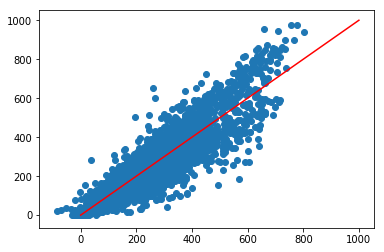

In [21]:
cat_model = CatBoostRegressor(task_type = 'GPU', iterations = 2000, random_seed = 42, verbose = False)
cat_model.fit(x_train, y_train)

cat_y_pred = np.floor(cat_model.predict(x_test))

print(np.sqrt(mean_squared_error(y_test, cat_y_pred)))
print(cat_model.feature_importances_)

plt.plot([0,1000],[0,1000], color='red')
plt.scatter(cat_y_pred, y_test)
plt.show()

E:\Programs\Anaconda\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


62.35180743623294


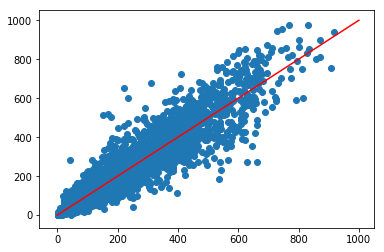

In [22]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'task': 'predict',
    'metric': {'l2', 'l1'},
    'num_leaves': 21,
    'learning_rate': 0.05,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.99,
    'bagging_freq': 4,
    'verbose': 0,
    'n_estimators': 3500,
    'seed': 42,
    'max_depth': 7,
    'max_delta_step': 0.4,
    'xgboost_dart_mode ': True
}

lgb_train = LGB.Dataset(x_train, y_train)

lgb_model = LGB.train(params, lgb_train)

lgb_y_pred = np.floor(lgb_model.predict(x_test))

print(np.sqrt(mean_squared_error(y_test, lgb_y_pred)))

plt.plot([0,1000],[0,1000], color='red')
plt.scatter(lgb_y_pred, y_test)
plt.show()

Let's see how well the average of all values does.

Credits to https://www.kaggle.com/maviator/simple-sklearn-models-averaging-to-get-to-13 for this function

In [23]:
def averagingModels(X, train, labels, models=[]):
    for model in models:
        if model == lgb_model:
            LGB.train(params, LGB.Dataset(train, labels))
        else:
            model.fit(train, labels)
        
        print('Finished Model')
            
    predictions = np.column_stack([model.predict(X) for model in models])
    return np.mean(predictions, axis=1)

E:\Programs\Anaconda\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Finished Model
Finished Model
Finished Model
Finished Model
Finished Model
Mean Squared Error: 62.81876354657406


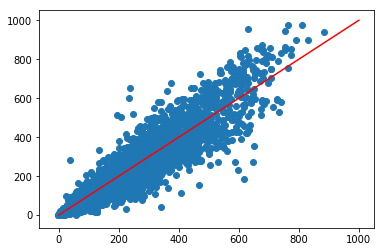

In [24]:
y_pred = averagingModels(x_test, x_train, y_train, [lgb_model, et_model, rf_model, xgb_model, cat_model])

print('Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

plt.plot([0,1000],[0,1000], color='red')
plt.scatter(y_pred, y_test)
plt.show()

Meh... I've had better results with a single XGBoost model. Let's see the score this would get me on the leaderboard

You could also try weighing the results based on their score

Run all models on all data avaliable to get a much better result!

In [25]:
full_set = train.copy()

x_full = full_set.drop('cnt', axis = 1)
y_full = full_set.cnt

y_solution_predict = averagingModels(test, x_full, y_full, [lgb_model, et_model, rf_model, xgb_model, cat_model])

solution['cnt'] = np.floor(y_solution_predict).clip(0)

solution['cnt'] = solution['cnt'].astype('int')

solution.to_csv('new_solution.csv', index = False)

E:\Programs\Anaconda\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Finished Model
Finished Model
Finished Model
Finished Model
Finished Model


60.02621 Score!!! Wow that's actually an improvement which I did not expect!

There is so much room for improvement. As showcased by the number 1. *cough* Bobby.

Somehow there must be some pattern I missed.